# importation de package

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module=".*pandas.*")

import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, regularizers
import PIL
import os
import fnmatch
import pathlib
import shutil
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from collections import Counter  # Pour vérifier l'équilibre des classes

# chargement de données

In [2]:
dt_path = 'dataset/'

In [3]:
# Vérifier les sous-dossiers
class_dirs = {
    class_name: os.path.join(dt_path, class_name)
    for class_name in os.listdir(dt_path)
    if os.path.isdir(os.path.join(dt_path, class_name))
}
print("Classes trouvées :", list(class_dirs.keys()))

Classes trouvées : ['cats', 'dogs']


In [4]:
# Lister les fichiers et leurs étiquettes
image_paths = []
labels = []
class_names = sorted(class_dirs.keys())  # Ex. ['cats', 'dogs']
class_to_index = {name: idx for idx, name in enumerate(class_names)}  # {'cats': 0, 'dogs': 1}

for class_name, class_dir in class_dirs.items():
    for filename in os.listdir(class_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, filename))
            labels.append(class_to_index[class_name])

# Vérifier l'équilibre des classes
print("Distribution des classes :", Counter(labels))

Distribution des classes : Counter({0: 10000, 1: 10000})


In [5]:

# Si les classes sont déséquilibrées, sous-échantillonner ou suréchantillonner
min_samples = min(Counter(labels).values())  # Nombre minimum d'exemples par classe
balanced_paths = []
balanced_labels = []
for class_idx in set(labels):
    class_paths = [p for p, l in zip(image_paths, labels) if l == class_idx]
    balanced_paths.extend(class_paths[:min_samples])
    balanced_labels.extend([class_idx] * min_samples)

image_paths = balanced_paths
labels = balanced_labels
print(f"Nombre total d'images après équilibrage : {len(image_paths)}")
print("Distribution après équilibrage :", Counter(labels))

Nombre total d'images après équilibrage : 20000
Distribution après équilibrage : Counter({0: 10000, 1: 10000})


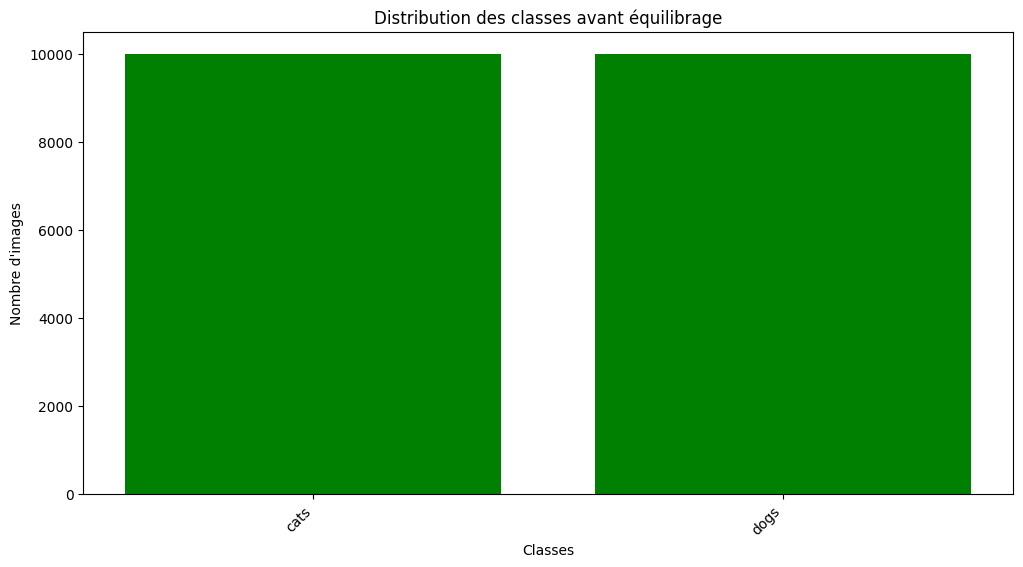

In [6]:
class_counts = {class_name: len(os.listdir(class_path)) for class_name, class_path in class_dirs.items()}

# Tracer la distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Classes")
plt.ylabel("Nombre d'images")
plt.title("Distribution des classes avant équilibrage")
plt.show()

In [7]:
# Diviser les données de manière stratifiée et équilibrée
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Nombre d'images d'entraînement : {len(train_paths)}")
print(f"Nombre d'images de validation : {len(valid_paths)}")
print("Distribution entraînement :", Counter(train_labels))
print("Distribution validation :", Counter(valid_labels))

Nombre d'images d'entraînement : 16000
Nombre d'images de validation : 4000
Distribution entraînement : Counter({1: 8000, 0: 8000})
Distribution validation : Counter({1: 2000, 0: 2000})


In [8]:
IMG_HEIGHT, IMG_WIDTH = 150, 150  # Taille réduite pour un modèle moins complexe
BATCH_SIZE = 32

def load_and_preprocess_image(path, label):
    try:
        img = tf.io.read_file(path)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = img / 255.0  # Normalisation entre 0 et 1
        return img, label
    except (tf.errors.InvalidArgumentError, tf.errors.OutOfRangeError):
        tf.print("Erreur lors du chargement de l'image :", path)
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3], dtype=tf.float32), label

In [9]:
# Créer les datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
# Ajouter une légère augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(buffer_size=500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Vérifier un batch
for images, labels in train_dataset.take(1):
    print("Shape des images :", images.shape)
    print("Labels :", labels.numpy())

Shape des images : (32, 150, 150, 3)
Labels : [1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1]


# Selection  du modèle

In [11]:
model = Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),  # Réduit à 16 filtres
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Réduit à 32 filtres
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Réduit à 64 filtres
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Réduit à 128 neurones
    layers.Dropout(0.3),  # Réduit le taux de dropout
    layers.Dense(2, activation='softmax')  # 2 classes
])

# Compiler avec un taux d'apprentissage bas
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,678,178 (10.22 MB)

 Trainable params: 2,678,178 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

# Entrainement du modèle

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs = 40
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 111s 219ms/step - accuracy: 0.5676 - loss: 1.6759 - val_accuracy: 0.7280 - val_loss: 0.6744
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 169ms/step - accuracy: 0.7068 - loss: 0.6588 - val_accuracy: 0.7345 - val_loss: 0.5914
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 219ms/step - accuracy: 0.7179 - loss: 0.5994 - val_accuracy: 0.7570 - val_loss: 0.5515
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 161ms/step - accuracy: 0.7345 - loss: 0.5714 - val_accuracy: 0.7563 - val_loss: 0.5426
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - accuracy: 0.7384 - loss: 0.5612 - val_accuracy: 0.7648 - val_loss: 0.5349
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 146ms/step - accuracy: 0.7452 - loss: 0.5478 - val_accuracy: 0.7623 - val_loss: 0.5293
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 152ms/step - accuracy: 0.7523 - loss: 0.5433 - val_accuracy: 0.7410 - val_loss: 0.5507
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 156ms/step - accuracy: 0.7626 - loss:

# Visualisation

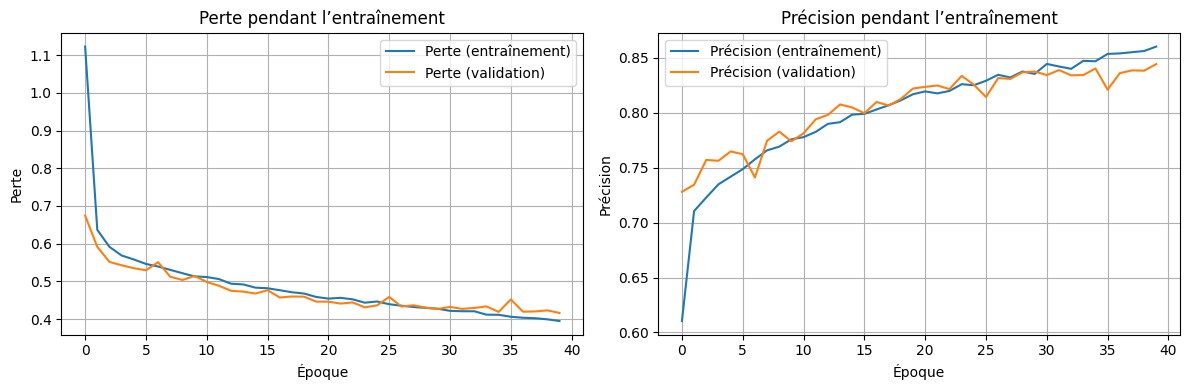

In [13]:
# Étape 7 : Visualiser les performances
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte (entraînement)')
plt.plot(history.history['val_loss'], label='Perte (validation)')
plt.title('Perte pendant l’entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision (entraînement)')
plt.plot(history.history['val_accuracy'], label='Précision (validation)')
plt.title('Précision pendant l’entraînement')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation 

In [14]:

val_loss, val_accuracy = model.evaluate(valid_dataset)
print(f"Perte sur l'ensemble de validation : {val_loss:.4f}")
print(f"Précision sur l'ensemble de validation : {val_accuracy:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8399 - loss: 0.4209
Perte sur l'ensemble de validation : 0.4161
Précision sur l'ensemble de validation : 0.8443


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


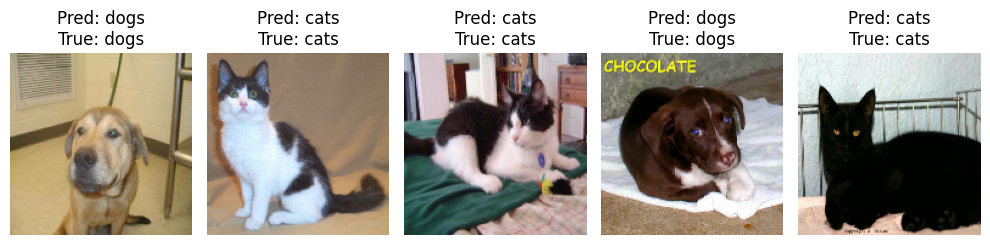

In [19]:
# Définir le mapping index -> nom de classe
index_to_class = {idx: name for idx, name in enumerate(class_names)}

# Prédire sur un batch de validation
for images, true_labels in valid_dataset.take(1):
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = true_labels.numpy()


    # Visualisation (optionnel)
    plt.figure(figsize=(10, 5))
    for i in range(min(5, len(images))):  # Afficher 5 images
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Pred: {index_to_class[predicted_classes[i]]}\nTrue: {index_to_class[true_classes[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Prédiction pour D:\intro\dataset\dogs\dog.12.jpg : dogs, Confiance : 0.8759


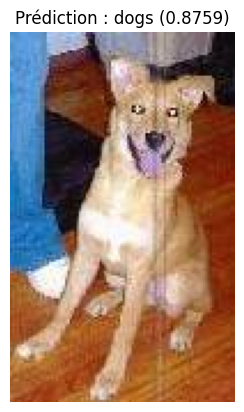

In [16]:

def predict_new_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0
    img = tf.expand_dims(img, 0)  # Ajouter une dimension batch
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class]
    return index_to_class[predicted_class], confidence

# Exemple : Prédire sur une nouvelle image (ajustez le chemin)
new_image_path = 'D:\intro\dataset\dogs\dog.12.jpg'  # Remplacez par un chemin réel
if os.path.exists(new_image_path):
    pred_class, confidence = predict_new_image(new_image_path)
    print(f"Prédiction pour {new_image_path} : {pred_class}, Confiance : {confidence:.4f}")
    img = load_img(new_image_path)
    plt.imshow(img)
    plt.title(f"Prédiction : {pred_class} ({confidence:.4f})")
    plt.axis('off')
    plt.show()
else:
    print("Chemin de l'image invalide. Fournissez un chemin correct.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Prédiction pour D:\intro\dataset\cats\cat.20.jpg : cats, Confiance : 0.7892


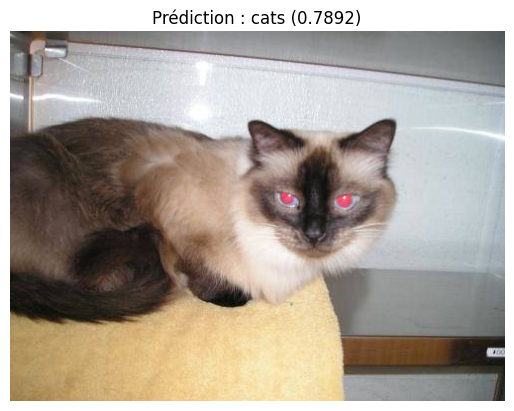

In [18]:
# Fonction pour prédire une nouvelle image
def predict_new_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0
    img = tf.expand_dims(img, 0)  # Ajouter une dimension batch
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class]
    return index_to_class[predicted_class], confidence

# Exemple : Prédire sur une nouvelle image (ajustez le chemin)
new_image_path = 'D:\intro\dataset\cats\cat.20.jpg'  # Remplacez par un chemin réel
if os.path.exists(new_image_path):
    pred_class, confidence = predict_new_image(new_image_path)
    print(f"Prédiction pour {new_image_path} : {pred_class}, Confiance : {confidence:.4f}")
    img = load_img(new_image_path)
    plt.imshow(img)
    plt.title(f"Prédiction : {pred_class} ({confidence:.4f})")
    plt.axis('off')
    plt.show()
else:
    print("Chemin de l'image invalide. Fournissez un chemin correct.")